This is the code for random forest feature selection by Raymond Xu.

 In this edition, the longitude and latitude of the original wildfire dataset is used as inputs.

 Here the temporal sequence is not considered in the data splitting.
 

In [9]:
''' This is Research Project titled ML Algorithms for Alberta Forest Occurence Prediction.
    This is the 8th Engineering Research Project, and is hereby delcared as
                            
                            Project Christopher
    
    Version 1.0 - Feature Importance on Random Forest Classifier Optimisation Result
    Data Source: European Space Agency - ERA5
                 Government of Alberta - Historical Wildfire registry and Fire Weather Indices
                 Natural Resources Canada - Vegetation Classification of Canada
    
    AI Diederik - Hongik Ingan, For the Benefits of All Mankind
'''

import math
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
set_config(transform_output = "pandas")

Importing dada from Google Drive. 
The fire events were using the original lat and lon, while the non-fire events are using the ERA5 grid.

In [29]:

# Load wildfire and non-wildfire datasets
main_df = pd.read_csv("G:/Shared drives/MECE 788 - Forest Fire Prediction/04_Preprocessing/Cleanup_and_point_selection/downsampled_df.csv",index_col=0)

# Remove the first unnamed column
wf_df=main_df[main_df['fire']==1]
nwf_df=main_df[main_df['fire']==0]

# Define Split ratio, aka percentage of the combined data goes to training
split=[0.6,0.2,0.2]
wf_sort = wf_df.sort_values(by='date')
nwf_sort = nwf_df.sort_values(by='date')


for i in [0,1,2]:
    wf_memory=0
    nfw_memory=0
    wf_selected=[]
    nwf_selected=[]
    wf_size = int(split[i] * len(wf_df))
    nwf_size = int(split[i] * len(nwf_df))
    if i==0:
        wf_selected=wf_sort[:wf_size]
        nwf_selected=nwf_sort[:nwf_size]
        wf_memory=wf_size
        nwf_memory=nwf_size
        train_data = pd.concat([wf_selected, nwf_selected])
    if i==1:
        wf_selected=wf_sort[wf_memory:wf_memory+wf_size]
        nwf_selected=nwf_sort[nwf_memory:nwf_memory+nwf_size]
        wf_memory=wf_size
        nwf_memory=nwf_size
        test_data = pd.concat([wf_selected, nwf_selected])
    if i==2:
        wf_selected=wf_sort[wf_memory:]
        nwf_selected=nwf_sort[nwf_memory:]
        val_data = pd.concat([wf_selected, nwf_selected])                

X_train = train_data.drop(columns={'fire','date'})
X_test = test_data.drop(columns={'fire','date'})
X_val = val_data.drop(columns={'fire','date'})
y_train = train_data['fire']
y_test = test_data['fire']
y_val = val_data['fire']


In [20]:
# Output sizes of training, testing, and validation sets
print('-------------------------------------')
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

-------------------------------------
Training set size: 49153
Testing set size: 6144


Set up the pipeline

In [56]:
# Manual separate numerical and categorical columns
pass_features = [ 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'slope_of_sub_gridscale_orography']
numeric_features = train_data.drop(columns=pass_features).keys().drop(['fire','date'])
categorical_features = ['type_of_high_vegetation', 'type_of_low_vegetation']
#numeric_features = numeric_features.insert(-1,'distance_to_road') Resevered for future development
feature_names ={'reserved'}#Columns to keep

# Define numeric and categorical transformer below
scale=ColumnTransformer([('scale_transformer',StandardScaler(),numeric_features)],verbose_feature_names_out=False).set_output(transform='pandas')

cate=ColumnTransformer([('categorical_transformer',OneHotEncoder(sparse_output=False),categorical_features)],verbose_feature_names_out=False).set_output(transform='pandas')

pss=ColumnTransformer([('Pass_transformer','passthrough',pass_features)],verbose_feature_names_out=False).set_output(transform='pandas')
Drop_transformer=ColumnTransformer([('Drop_transformer','passthrough',feature_names)],verbose_feature_names_out=False).set_output(transform='pandas')

Data_pipeline = Pipeline(steps=[
    ('Feature Union',FeatureUnion([('numeric', scale),('categorical',cate),('pass',pss)])),
    ]
    )

In [58]:
X_train_processed=Data_pipeline.fit_transform(X_train)
X_test_processed=Data_pipeline.transform(X_test)

In [59]:
X_train.keys()

Index(['latitude', 'longitude', 'high_vegetation_cover',
       'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
       'low_vegetation_cover', 'slope_of_sub_gridscale_orography',
       'type_of_high_vegetation', 'type_of_low_vegetation',
       '24hr_accumulated_precipitation', '24hr_max_temperature',
       'global_noon_LST_2m_temperature', 'global_noon_LST_relative_humidity',
       'global_noon_LST_wind_speed', 'BUI', 'DC', 'DMC', 'FFMC', 'FWI',
       'fire_count_past_3Days', 'fire_count_past_7Days',
       'fire_count_past_10Days', 'fire_count_past_30Days',
       '24hr_max_temperature_1dayLag', '24hr_max_temperature_2dayLag',
       'global_noon_LST_2m_temperature_1dayLag',
       'global_noon_LST_2m_temperature_2dayLag'],
      dtype='object')

In [34]:
# SelectKB
from sklearn.feature_selection import SelectKBest, f_classif,chi2
SelectKB_train = SelectKBest(f_classif,k=10)
SelectKB_train.fit(pd.DataFrame(X_train_processed,columns=X_train_processed.columns),y_train)
feature_names=SelectKB_train.get_feature_names_out()
print('Based on the Selected KBest Algorithm, the following 10 features should be selected:')
print(feature_names)

# PCA Analysis
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_processed)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_90 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_90 = X_train_processed.shape[1] - n_over_90 + 1
print('-------------PCA Analysis----------------')
print("Number of features in the original dataset: {}".format(X_train_processed.shape[1]))
print("Number of features: {}\tTotal Variance Explained: {}".format(n_to_reach_90, total_explained_variance[n_to_reach_90-1]))


Based on the Selected KBest Algorithm, the following 10 features should be selected:
['numeric__global_noon_LST_2m_temperature'
 'numeric__global_noon_LST_relative_humidity' 'numeric__FFMC'
 'numeric__24hr_max_temperature_1dayLag'
 'numeric__global_noon_LST_2m_temperature_1dayLag'
 'numeric__global_noon_LST_2m_temperature_2dayLag'
 'pass__fire_count_past_3Days' 'pass__fire_count_past_7Days'
 'pass__fire_count_past_10Days' 'pass__fire_count_past_30Days']
-------------PCA Analysis----------------
Number of features in the original dataset: 37
Number of features: 10	Total Variance Explained: 0.9012080791111745


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer


# Initialize and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'n_estimators': [800],  # Number of trees in the forest
    'max_depth': [8],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [2,10],
    'min_samples_split': [5,7]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=1)
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [5, 7], 'n_estimators': [800]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro),
             verbose=1)

In [62]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

Best parameters: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 800}
F1 Score: 75.14%


In [63]:
best_classifier = grid_search.best_estimator_

# Predict on the validation set
y_test_pred = best_classifier.predict(X_test_processed)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_test, y_test_pred))



Validation set accuracy: 0.8256599140577041
f1 score:  0.6068157614483493


C:\Users\Home Office\AppData\Local\Temp\ipykernel_18404\2010776610.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index)


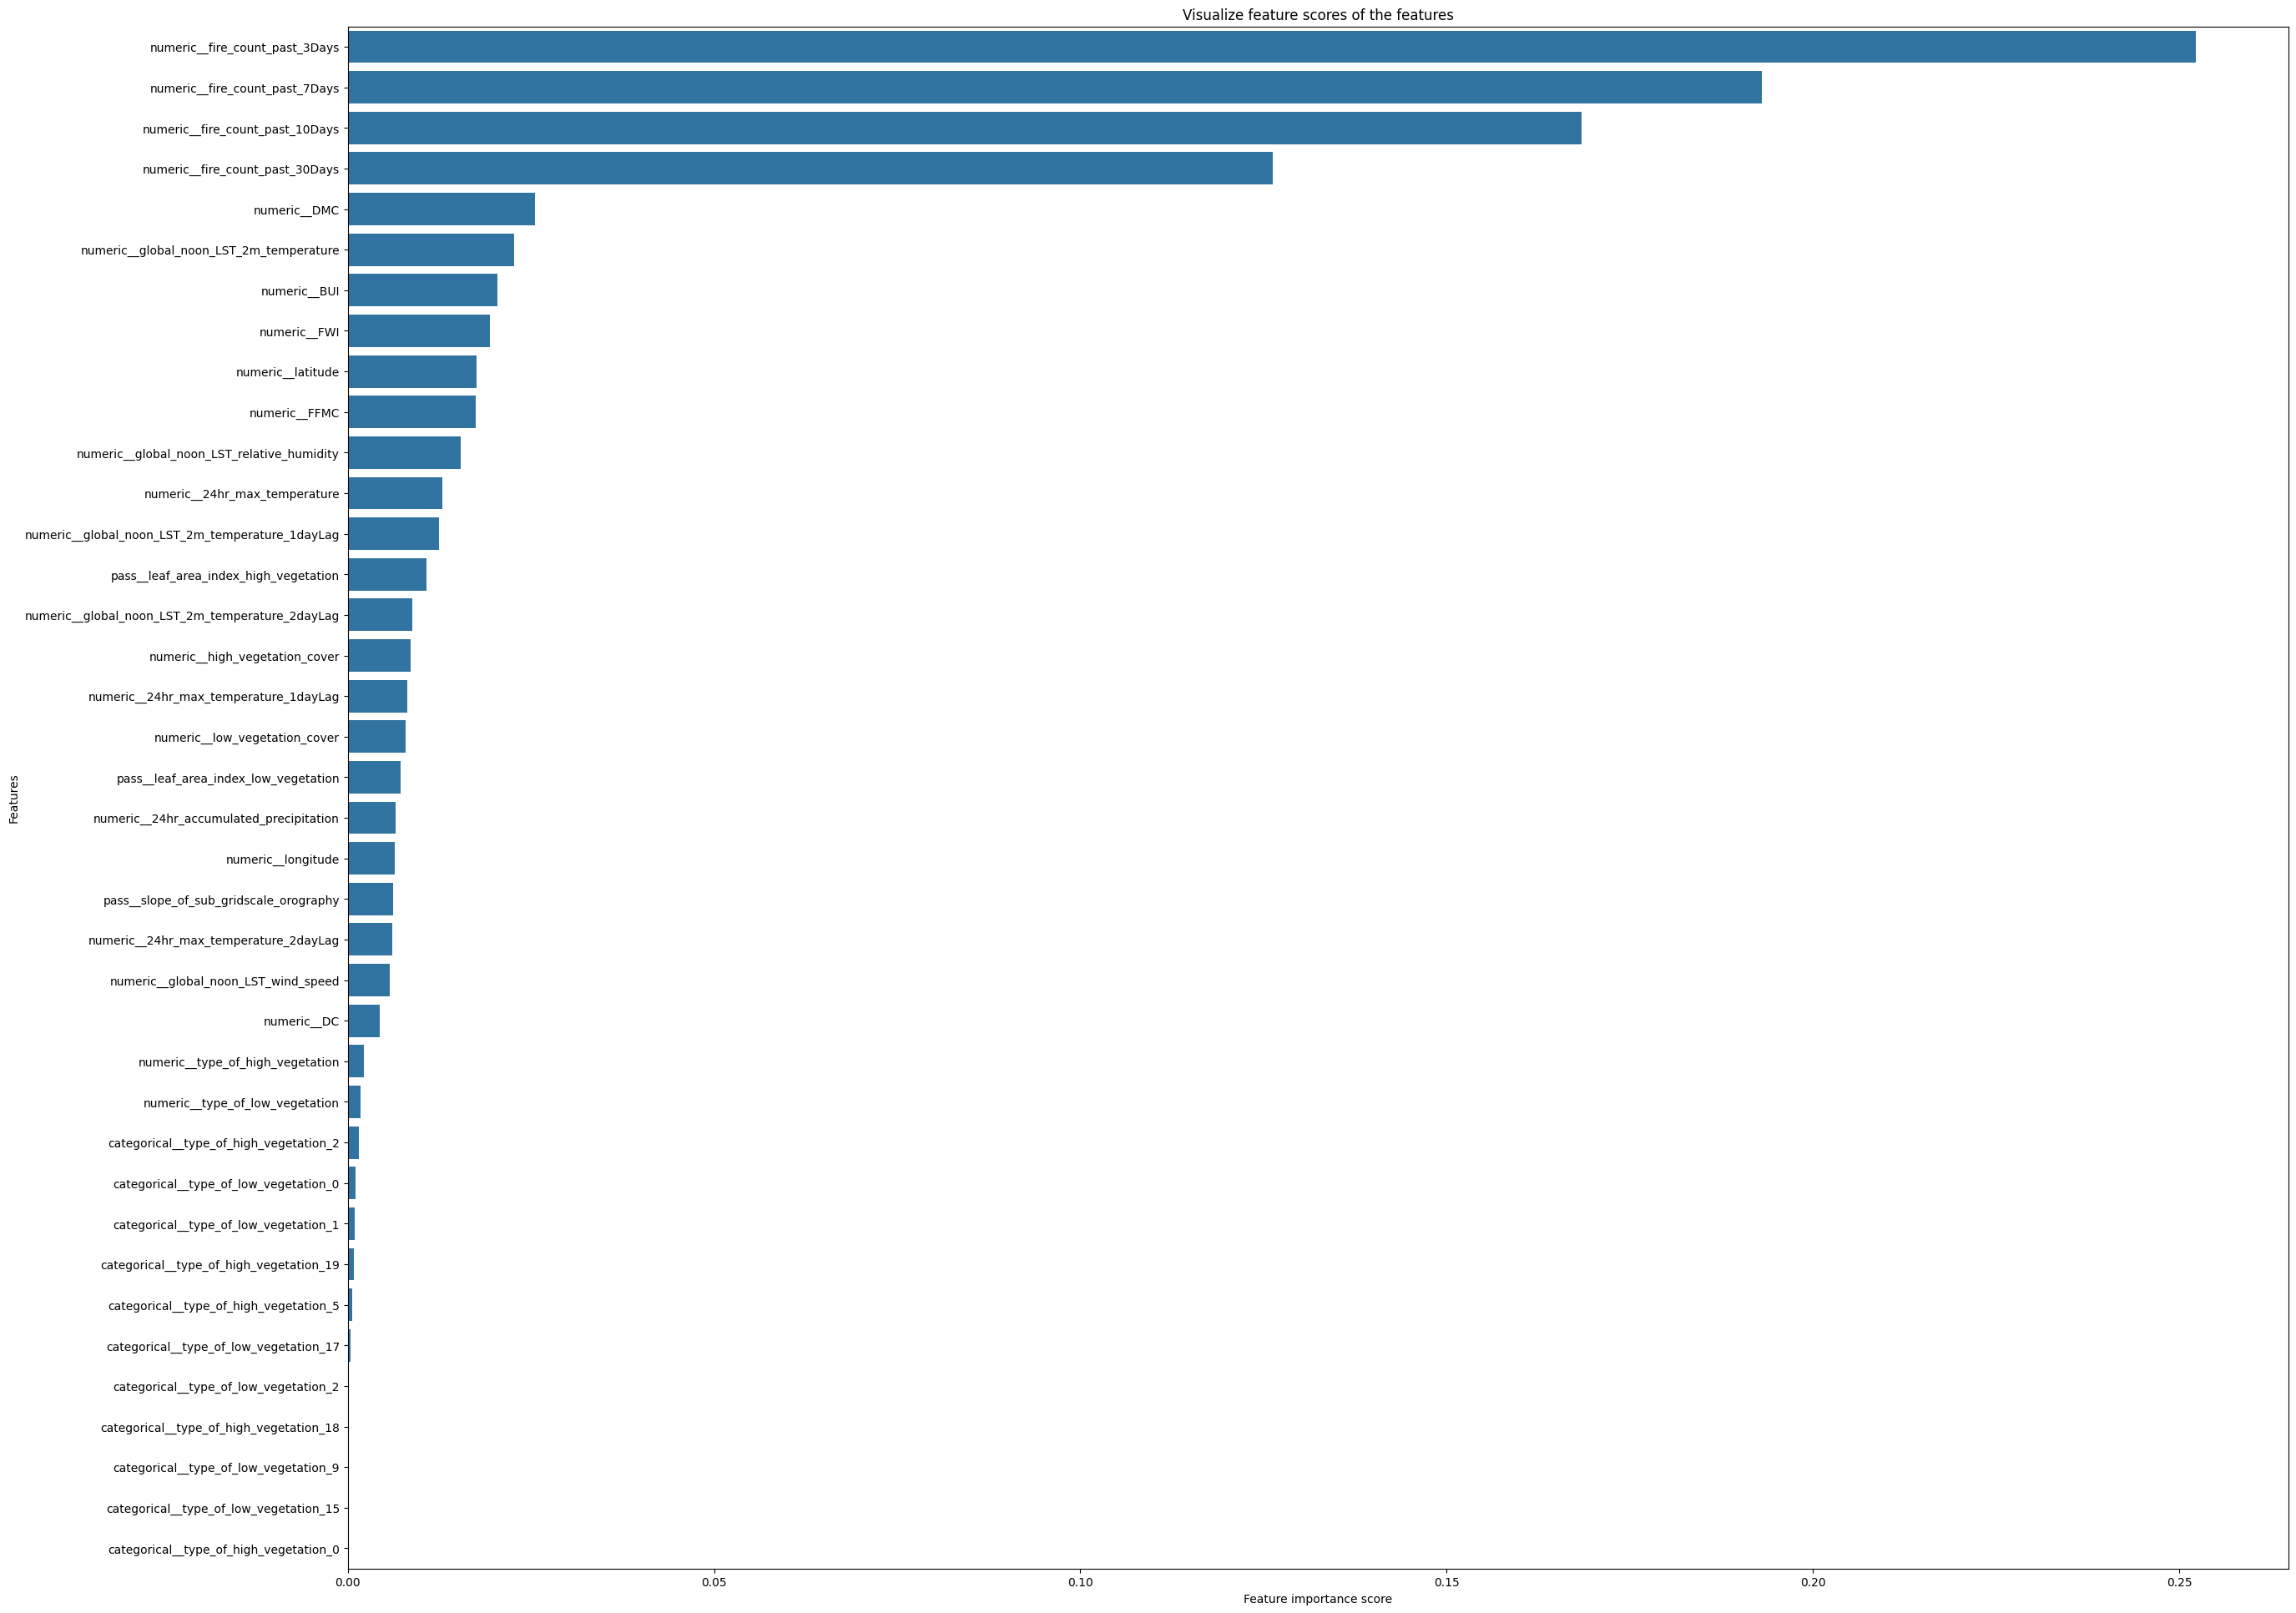

Validation set accuracy: 0.8256599140577041
f1 score:  0.6068157614483493


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_scores = pd.Series(best_classifier.feature_importances_, index=X_train_processed.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()


# Predict on the validation set
y_test_pred = best_classifier.predict(X_test_processed)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_test, y_test_pred))

In [65]:
feature_scores

numeric__fire_count_past_3Days                     0.252285
numeric__fire_count_past_7Days                     0.193044
numeric__fire_count_past_10Days                    0.168429
numeric__fire_count_past_30Days                    0.126317
numeric__DMC                                       0.025564
numeric__global_noon_LST_2m_temperature            0.022685
numeric__BUI                                       0.020464
numeric__FWI                                       0.019396
numeric__latitude                                  0.017524
numeric__FFMC                                      0.017485
numeric__global_noon_LST_relative_humidity         0.015353
numeric__24hr_max_temperature                      0.012945
numeric__global_noon_LST_2m_temperature_1dayLag    0.012480
pass__leaf_area_index_high_vegetation              0.010740
numeric__global_noon_LST_2m_temperature_2dayLag    0.008820
numeric__high_vegetation_cover                     0.008521
numeric__24hr_max_temperature_1dayLag   